# Your own few-shot classification model ready in 15mn with PyTorch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb)

I have been working on few-shot classification for a while now. The more I talk about it, the more the people around me seem to feel that it's some kind of dark magic. Even sadder: I noticed that very few actually used it on their projects. I think that's too bad, so I decided to make a tutorial so you'll have no excuse to deprive yourself of the power of few-shot learning methods.

In 15 minutes and just a few lines of code, we are going to implement
the [Prototypical Networks](https://arxiv.org/abs/1703.05175). It's the favorite method of
many few-shot learning researchers (~2000 citations in 3 years), because 1) it works well,
and 2) it's incredibly easy to grasp and to implement.

## Discovering Prototypical Networks
First, let's install the [tutorial GitHub repository](https://github.com/sicara/easy-few-shot-learning) and import some packages. If you're on Colab right now, you should also check that you're using a GPU (Edit > Notebook settings).

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import alexnet
import torch.nn.functional as F
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [2]:
image_size = 28

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = CIFAR10(
    root="../data",
    transform=transforms.Compose(
        [
            transforms.Resize(224),
            # transforms.RandomResizedCrop(image_size),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
        ]
    ),
    download=True,
)
test_set = CIFAR10(
    root="../data",
    transform=transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
        ]
    ),
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def one_hot(indices, depth):
    """
    Returns a one-hot tensor.
    This is a PyTorch equivalent of Tensorflow's tf.one_hot.
        
    Parameters:
      indices:  a (n_batch, m) Tensor or (m) Tensor.
      depth: a scalar. Represents the depth of the one hot dimension.
    Returns: a (n_batch, m, depth) Tensor or (m, depth) Tensor.
    """

    encoded_indicies = torch.zeros(indices.size() + torch.Size([depth]))#.cuda()
    index = indices.view(indices.size()+torch.Size([1]))
    encoded_indicies = encoded_indicies.scatter_(1,index,1)
    
    return encoded_indicies

def computeGramMatrix(A, B):
    """
    Constructs a linear kernel matrix between A and B.
    We assume that each row in A and B represents a d-dimensional feature vector.
    
    Parameters:
      A:  a (n_batch, n, d) Tensor.
      B:  a (n_batch, m, d) Tensor.
    Returns: a (n_batch, n, m) Tensor.
    """
    
    assert(A.dim() == 3)
    assert(B.dim() == 3)
    assert(A.size(0) == B.size(0) and A.size(2) == B.size(2))

    return torch.bmm(A, B.transpose(1,2))

In [4]:
def SubspaceNetHead(query, support, support_labels, n_way, n_shot, normalize=True):
    """
       Constructs the subspace representation of each class(=mean of support vectors of each class) and
       returns the classification score (=L2 distance to each class prototype) on the query set.

        Our algorithm using subspaces here
        https://github.com/chrysts/dsn_fewshot/blob/master/Resnet12/models/classification_heads.py

       Parameters:
         query:  a (tasks_per_batch, n_query, d) Tensor.
         support:  a (tasks_per_batch, n_support, d) Tensor.
         support_labels: a (tasks_per_batch, n_support) Tensor.
         n_way: a scalar. Represents the number of classes in a few-shot classification task.
         n_shot: a scalar. Represents the number of support examples given per class.
         normalize: a boolean. Represents whether if we want to normalize the distances by the embedding dimension.
       Returns: a (tasks_per_batch, n_query, n_way) Tensor.
    """

    query = query.unsqueeze(0)
    support = support.unsqueeze(0)
    support_labels = support_labels.unsqueeze(0)

    tasks_per_batch = query.size(0)
    n_support = support.size(1)
    n_query = query.size(1)
    d = query.size(2)

    assert(query.dim() == 3)
    assert(support.dim() == 3)
    assert(query.size(0) == support.size(0) and query.size(2) == support.size(2))
    assert(n_support == n_way * n_shot)      # n_support must equal to n_way * n_shot

    support_labels_one_hot = one_hot(support_labels.view(tasks_per_batch * n_support), n_way)
    #support_labels_one_hot = support_labels_one_hot.view(tasks_per_batch, n_support, n_way)


    support_reshape = support.view(tasks_per_batch * n_support, -1)

    support_labels_reshaped = support_labels.contiguous().view(-1)
    class_representatives = []
    for nn in range(n_way):
        idxss = (support_labels_reshaped == nn).nonzero()
        all_support_perclass = support_reshape[idxss, :]
        class_representatives.append(all_support_perclass.view(tasks_per_batch, n_shot, -1))

    class_representatives = torch.stack(class_representatives)
    class_representatives = class_representatives.transpose(0, 1) #tasks_per_batch, n_way, n_support, -1
    class_representatives = class_representatives.transpose(2, 3).contiguous().view(tasks_per_batch*n_way, -1, n_shot)

    dist = []
    for cc in range(tasks_per_batch*n_way):
        batch_idx = cc//n_way
        qq = query[batch_idx]
        uu, _, _ = torch.svd(class_representatives[cc].double())
        uu = uu.float()
        subspace = uu[:, :n_shot-1].transpose(0, 1)
        projection = subspace.transpose(0, 1).mm(subspace.mm(qq.transpose(0, 1))).transpose(0, 1)
        dist_perclass = torch.sum((qq - projection)**2, dim=-1)
        dist.append(dist_perclass)

    dist = torch.stack(dist).view(tasks_per_batch, n_way, -1).transpose(1, 2)
    logits = -dist

    if normalize:
        logits = logits / d
    
    return logits

In [5]:
def ProtoNetHead(query, support, support_labels, n_way, n_shot, normalize=True):
    """
    Constructs the prototype representation of each class(=mean of support vectors of each class) and 
    returns the classification score (=L2 distance to each class prototype) on the query set.
    
    This model is the classification head described in:
    Prototypical Networks for Few-shot Learning
    (Snell et al., NIPS 2017).
    
    Parameters:
      query:  a (tasks_per_batch, n_query, d) Tensor.
      support:  a (tasks_per_batch, n_support, d) Tensor.
      support_labels: a (tasks_per_batch, n_support) Tensor.
      n_way: a scalar. Represents the number of classes in a few-shot classification task.
      n_shot: a scalar. Represents the number of support examples given per class.
      normalize: a boolean. Represents whether if we want to normalize the distances by the embedding dimension.
    Returns: a (tasks_per_batch, n_query, n_way) Tensor.
    """

    query = query.unsqueeze(0)
    support = support.unsqueeze(0)
    support_labels = support_labels.unsqueeze(0)

    tasks_per_batch = query.size(0)
    n_support = support.size(1)
    n_query = query.size(1)
    d = query.size(2)

    
    assert(query.dim() == 3)
    assert(support.dim() == 3)
    assert(query.size(0) == support.size(0) and query.size(2) == support.size(2))
    assert(n_support == n_way * n_shot)      # n_support must equal to n_way * n_shot
    
    support_labels_one_hot = one_hot(support_labels.view(tasks_per_batch * n_support), n_way)
    support_labels_one_hot = support_labels_one_hot.view(tasks_per_batch, n_support, n_way)
    
    # From:
    # https://github.com/gidariss/FewShotWithoutForgetting/blob/master/architectures/PrototypicalNetworksHead.py
    #************************* Compute Prototypes **************************
    labels_train_transposed = support_labels_one_hot.transpose(1,2)

    prototypes = torch.bmm(labels_train_transposed, support)
    # Divide with the number of examples per novel category.
    prototypes = prototypes.div(
        labels_train_transposed.sum(dim=2, keepdim=True).expand_as(prototypes)
    )

    # Distance Matrix Vectorization Trick
    AB = computeGramMatrix(query, prototypes)
    AA = (query * query).sum(dim=2, keepdim=True)
    BB = (prototypes * prototypes).sum(dim=2, keepdim=True).reshape(tasks_per_batch, 1, n_way)
    logits = AA.expand_as(AB) - 2 * AB + BB.expand_as(AB)
    logits = -logits

    
    if normalize:
        logits = logits / d

    return logits
    

In [6]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module, head: str):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)
    
        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Infer the number shots from the labels of the support set
        n_shot = len(torch.where(support_labels==support_labels[0])[0])

        if self.head == 'ProtoNet':
            scores = ProtoNetHead(z_query, z_support, support_labels, n_way, n_shot)
        elif self.head == 'SubspaceNet':
            scores = SubspaceNetHead(z_query, z_support, support_labels, n_way, n_shot)
        else:
            print('head not recognized')

        return scores


convolutional_network = alexnet(pretrained=True)
convolutional_network.classifier[6] = nn.Flatten()

model = PrototypicalNetworks(convolutional_network, 'ProtoNet') #.cuda()

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now we have a model! Note that we used a pretrained feature extractor,
so our model should already be up and running. Let's see that.

Here we create a dataloader that will feed few-shot classification tasks to our model.
But a regular PyTorch dataloader will feed batches of images, with no consideration for
their label or whether they are support or query. We need 2 specific features in our case.

1. We need images evenly distributed between a given number of classes.
2. We need them split between support and query sets.

For the first point, I wrote a custom sampler: it first samples `n_way` classes from the dataset,
then it samples `n_shot + n_query` images for each class (for a total of `n_way * (n_shot + n_query)`
images in each batch).
For the second point, I have a custom collate function to replace the built-in PyTorch `collate_fn`.
This baby feed each batch as the combination of 5 items:

1. support images
2. support labels between 0 and `n_way`
3. query images
4. query labels between 0 and `n_way`
5. a mapping of each label in `range(n_way)` to its true class id in the dataset
(it's not used by the model but it's very useful for us to know what the true class is)

You can see that in PyTorch, a DataLoader is basically the combination of a sampler, a dataset and a collate function
(and some multiprocessing voodoo): sampler says which items to fetch, the dataset says how to fetch them, and
the collate function says how to present these items together. If you want to dive into these custom objects,
they're [here](https://github.com/sicara/easy-few-shot-learning/tree/master/easyfsl/data_tools).

In [7]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [
    instance[1] for instance in test_set
]


test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

We created a dataloader that will feed us with 5-way 5-shot tasks (the most common setting in the litterature).
Now, as every data scientist should do before launching opaque training scripts,
let's take a look at our dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


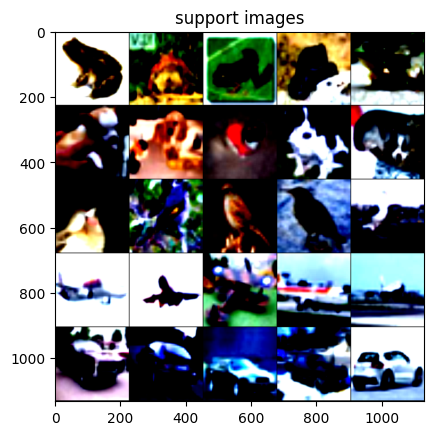

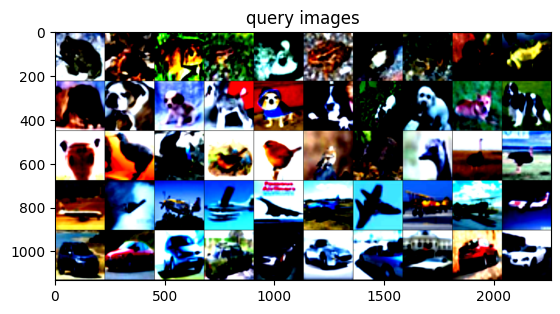

In [8]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

For both support and query set, you should have one line for each class.

How does our model perform on this task?

In [9]:
model.eval()
example_scores = model(
    example_support_images,
    example_support_labels,
    example_query_images,
).detach()

example_predicted_labels = torch.argmax(torch.squeeze(example_scores, axis=0),axis = 1)


In [10]:
torch.sum(example_predicted_labels ==example_query_labels).item()/len(example_query_labels)

0.62

This doesn't look bad: keep in mind that the model was trained on very different images, and has only seen 5 examples for each class!

Now that we have a first idea, let's see more precisely how good our model is.

In [11]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """


    return (
            torch.argmax(
             torch.squeeze(
                model(support_images, support_labels, query_images).detach().data, axis=0)
                ,axis = 1
                )
               ==example_query_labels).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:37<00:00,  2.64it/s]

Model tested on 100 tasks. Accuracy: 18.72%


## Training a meta-learning algorithm

Let's use the "background" images of Omniglot as training set. Here we prepare a data loader of 40 000 few-shot classification
tasks on which we will train our model. The alphabets used in the training set are entirely separated from those used in the testing set.
This guarantees that at test time, the model will have to classify characters that were not seen during training.

Note that we don't set a validation set here to keep this notebook concise,
but keep in mind that **this is not good practice** and you should always use validation when training a model for production.

Note: Currently, there is a bug in PyTorch DataLoader for Mac/Windows users that makes it impossible to use multiple workers with custom `get_labels` function.
You can set `num_workers=0` to avoid this issue when instantiating the DataLoader in the next cell.
Read more about the [issue](https://github.com/sicara/easy-few-shot-learning/issues/51).

In [12]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

We will keep the same model. So our weights will be pre-trained on ImageNet. If you want to start a training from scratch,
feel free to set `pretrained=False` in the definition of the ResNet.

Here we define our loss and our optimizer (cross entropy and Adam, pretty standard), and a `fit` method.
This method takes a classification task as input (support set and query set). It predicts the labels of the query set
based on the information from the support set; then it compares the predicted labels to ground truth query labels,
and this gives us a loss value. Then it uses this loss to update the parameters of the model. This is a *meta-training loop*.

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images, support_labels, query_images
    )
    
    train_way = len(torch.unique(support_labels))

    # smoothed_one_hot = one_hot(query_labels.reshape(-1), train_way)
    # # smoothed_one_hot = smoothed_one_hot * (1 - opt.eps) + (1 - smoothed_one_hot) * opt.eps / (opt.train_way - 1) setting eps = 0
    # log_prb = F.log_softmax(classification_scores.reshape(-1, train_way), dim=1)
    # loss = -(smoothed_one_hot * log_prb).sum(dim=1)
    # loss = loss.mean()


    loss = criterion(classification_scores.reshape(-1, train_way), query_labels.reshape(-1)) # need to modify this for subspace net
    loss.backward()
    optimizer.step()

    return loss.item()

To train the model, we are just going to iterate over a large number of randomly generated few-shot classification tasks,
and let the `fit` method update our model after each task. This is called **episodic training**.

This took me 20mn on an RTX 2080 and I promised you that this whole tutorial would take 15mn.
So if you don't want to run the training yourself, you can just skip the training and load the model that I trained
using the exact same code.

In [14]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))
            

 15%|█▌        | 6020/40000 [2:11:17<12:23:22,  1.31s/it, loss=0.687]

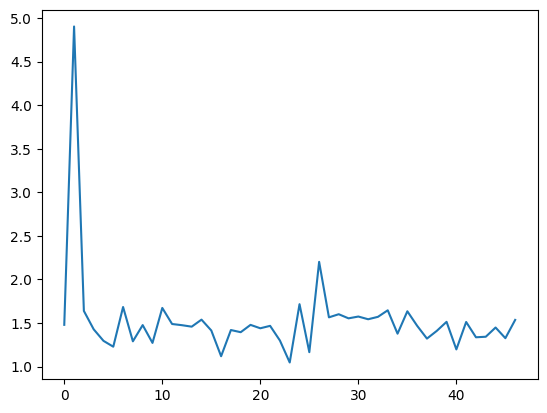

In [15]:
from matplotlib import pyplot as plt
plt.plot(all_loss)

In [19]:
# Or just load mine

!wget https://public-sicara.s3.eu-central-1.amazonaws.com/easy-fsl/resnet18_with_pretraining.tar
model.load_state_dict(torch.load("resnet18_with_pretraining.tar", map_location="cuda"))

/bin/bash: wget: command not found


FileNotFoundError: [Errno 2] No such file or directory: 'resnet18_with_pretraining.tar'

Now let's see if our model got better!

In [ ]:
evaluate(test_loader)

Around 98%!

It's not surprising that the model performs better after being further trained on Omniglot images than it was with its
ImageNet-based parameters. However, we have to keep in mind that the classes on which we just evaluated our model were still
**not seen during training**, so 99% (with a 12% improvement over the model trained on ImageNet) seems like a decent performance.

## What have we learned?

- What a Prototypical Network is and how to implement one in 15 lines of code.
- How to use Omniglot to evaluate few-shot models
- How to use custom PyTorch objets to sample batches in the shape of a few-shot classification tasks.
- How to use meta-learning to train a few-shot algorithm.

## What's next?

- Take this notebook in your own hands, tweak everything that there is to tweak. It's the best way to understand what does what.
- Implement other few-shot learning methods, such as Matching Networks, Relation Networks, MAML...
- Try other ways of training. Episodic training is not the only way to train a model to generalize to new classes!
- Experiment on other, more challenging few-shot learning benchmarks, such as [CUB](http://www.vision.caltech.edu/visipedia/CUB-200.html)
or [Meta-Dataset](https://github.com/google-research/meta-dataset).
- If you liked this tutorial, feel free to ⭐ [give us a star on Github](https://github.com/sicara/easy-few-shot-learning) ⭐
- **Contribute!** The companion repository of this notebook is meant to become a boilerplate, a source of useful code that
that newcomers can use to start their few-shot learning projects.
